In [1]:
# Imports. Nothing to see here.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

from imblearn.over_sampling import SMOTE
from gensim.models import Word2Vec
from collections import Counter

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import random

import sqlite3
from textblob import TextBlob

In [2]:
# databases within ['categories', 'podcasts', 'reviews', 'runs']

cnx = sqlite3.connect('D:\Flatiron\Capstone\database.sqlite')

podcast = pd.read_sql_query("SELECT * FROM podcasts", cnx)

categories = pd.read_sql_query("SELECT * FROM categories", cnx)

runs = pd.read_sql_query("SELECT * FROM runs", cnx)

reviews = pd.read_sql_query("SELECT * FROM reviews", cnx)

In [3]:
explore = pd.read_sql_query('''SELECT p.podcast_id, AVG(rating)
                            FROM podcasts p 
                            JOIN categories c 
                            ON p.podcast_id = c.podcast_id 
                            JOIN reviews r 
                            ON p.podcast_id = r.podcast_id 
                            GROUP BY p.podcast_id
                            ORDER BY AVG(rating)
                            ''', cnx)
explore


,podcast_id,AVG(rating)
0,a0004b1ef445af9dc84dad1e7821b1e3,1.0
1,a024f5f647d0877820ef9f4a8584f93a,1.0
2,a03abf5b7f0f58615ea36f0f8c4cefcc,1.0
3,a0459e0af7b8be2c886e867d58f1dedd,1.0
4,a05087d5a58f032cbc27562166f10186,1.0
...,...,...
46660,fffdfb5b49d0d47943e09f6213a346e5,5.0
46661,fffe308414050768d3ce3782aa503b7d,5.0
46662,fffe3f208a56dfecfaf6d0a7f8399d63,5.0
46663,ffff66f98c1adfc8d0d6c41bb8facfd0,5.0


In [4]:
data = pd.read_sql_query("SELECT * FROM podcasts p JOIN categories c USING (podcast_id) JOIN reviews r USING (podcast_id)", cnx)

In [5]:
data

,podcast_id,itunes_id,slug,itunes_url,title,category,title,content,rating,created_at
0,c61aa81c9b929a66f0c1db6cbe5d8548,1373261997,backstage-at-tilles-center,https://podcasts.apple.com/us/podcast/backstag...,Backstage at Tilles Center,arts,really interesting!,Thanks for providing these insights. Really e...,5,2018-04-24T12:05:16-07:00
1,c61aa81c9b929a66f0c1db6cbe5d8548,1373261997,backstage-at-tilles-center,https://podcasts.apple.com/us/podcast/backstag...,Backstage at Tilles Center,arts-performing-arts,really interesting!,Thanks for providing these insights. Really e...,5,2018-04-24T12:05:16-07:00
2,c61aa81c9b929a66f0c1db6cbe5d8548,1373261997,backstage-at-tilles-center,https://podcasts.apple.com/us/podcast/backstag...,Backstage at Tilles Center,music,really interesting!,Thanks for providing these insights. Really e...,5,2018-04-24T12:05:16-07:00
3,c61aa81c9b929a66f0c1db6cbe5d8548,1373261997,backstage-at-tilles-center,https://podcasts.apple.com/us/podcast/backstag...,Backstage at Tilles Center,arts,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5,2018-05-09T18:14:32-07:00
4,c61aa81c9b929a66f0c1db6cbe5d8548,1373261997,backstage-at-tilles-center,https://podcasts.apple.com/us/podcast/backstag...,Backstage at Tilles Center,arts-performing-arts,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5,2018-05-09T18:14:32-07:00
...,...,...,...,...,...,...,...,...,...,...
1425160,ddd451a18055f0108edf79f8c3c9bf15,1164278826,what-if-world-stories-for-kids,https://podcasts.apple.com/us/podcast/what-if-...,What If World - Stories for Kids,kids-family,Just want everyone to have fun 😊😊😊😊😊,I made this so all you guys that listen to thi...,5,2021-02-05T04:29:16-07:00
1425161,a08a93f2ef58f847b263c84d96e891f5,1223805240,inbox-besties-w-kate-doster-email-marketing-po...,https://podcasts.apple.com/us/podcast/inbox-be...,Inbox Besties w/ Kate Doster | Email Marketing...,business,Mind blowing content,I just discovered Kate Doster and the hype is ...,5,2021-02-04T14:31:55-07:00
1425162,f9255ade54a8e12df362cde70b49dff9,1461841525,the-trypod,https://podcasts.apple.com/us/podcast/the-tryp...,The TryPod,comedy,Way to many ads,This podcast as well as the “you can sit with ...,1,2021-02-04T17:09:19-07:00
1425163,f9255ade54a8e12df362cde70b49dff9,1461841525,the-trypod,https://podcasts.apple.com/us/podcast/the-tryp...,The TryPod,comedy,Meh.,Really crappy ep 2/4. I guess they can’t all b...,1,2021-02-04T17:41:06-07:00


In [6]:
# plt.hist(data['podcast_id'])
# plt.show()

In [7]:
print(data.shape)
data['podcast_id'].nunique()

(1425165, 10)


46665

In [8]:
data.drop(['itunes_url','itunes_id', 'created_at', 'title', 'podcast_id'], axis=1, inplace=True)

In [9]:
print(data.isna().sum())

slug        0
category    0
content     0
rating      0
dtype: int64


In [10]:
# Check for duplicated rows and preserve unique entries.

a = len(data)
data = data.drop_duplicates()
b = len(data)
print('# Number of duplicate rows dropped: {}'.format(a-b))

# Number of duplicate rows dropped: 2968


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1422197 entries, 0 to 1425164
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   slug      1422197 non-null  object
 1   category  1422197 non-null  object
 2   content   1422197 non-null  object
 3   rating    1422197 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 54.3+ MB


In [12]:
data.shape

(1422197, 4)

In [13]:
data['category'].unique()

array(['arts', 'arts-performing-arts', 'music', 'arts-design',
       'education', 'society-culture', 'arts-visual-arts', 'technology',
       'arts-food', 'society-culture-personal-journals', 'comedy',
       'arts-fashion-beauty', 'tv-film', 'society-culture-places-travel',
       'kids-family', 'religion-spirituality', 'business',
       'society-culture-philosophy', 'spirituality', 'business-careers',
       'christianity', 'hinduism', 'business-investing', 'judaism',
       'islam', 'buddhism'], dtype=object)

In [14]:
tokenizer = RegexpTokenizer(r'\w+')

stops = stopwords.words('english')
stops += list(string.punctuation)

In [15]:
data

,slug,category,content,rating
0,backstage-at-tilles-center,arts,Thanks for providing these insights. Really e...,5
1,backstage-at-tilles-center,arts-performing-arts,Thanks for providing these insights. Really e...,5
2,backstage-at-tilles-center,music,Thanks for providing these insights. Really e...,5
3,backstage-at-tilles-center,arts,Super excited to see this podcast grow. So man...,5
4,backstage-at-tilles-center,arts-performing-arts,Super excited to see this podcast grow. So man...,5
...,...,...,...,...
1425160,what-if-world-stories-for-kids,kids-family,I made this so all you guys that listen to thi...,5
1425161,inbox-besties-w-kate-doster-email-marketing-po...,business,I just discovered Kate Doster and the hype is ...,5
1425162,the-trypod,comedy,This podcast as well as the “you can sit with ...,1
1425163,the-trypod,comedy,Really crappy ep 2/4. I guess they can’t all b...,1


In [16]:
data ['slug'] = data['slug'].apply(lambda x: x.replace('-',' '))
data ['category'] = data['category'].apply(lambda x: x.replace('-',' '))
data ['category'] = data['category'].apply(lambda x: x.split()[0])
data

,slug,category,content,rating
0,backstage at tilles center,arts,Thanks for providing these insights. Really e...,5
1,backstage at tilles center,arts,Thanks for providing these insights. Really e...,5
2,backstage at tilles center,music,Thanks for providing these insights. Really e...,5
3,backstage at tilles center,arts,Super excited to see this podcast grow. So man...,5
4,backstage at tilles center,arts,Super excited to see this podcast grow. So man...,5
...,...,...,...,...
1425160,what if world stories for kids,kids,I made this so all you guys that listen to thi...,5
1425161,inbox besties w kate doster email marketing po...,business,I just discovered Kate Doster and the hype is ...,5
1425162,the trypod,comedy,This podcast as well as the “you can sit with ...,1
1425163,the trypod,comedy,Really crappy ep 2/4. I guess they can’t all b...,1


In [17]:
# data['all'] = data['slug'] + ' ' + data['content']

In [18]:
data['content'] = data['content'].apply(tokenizer.tokenize)

data['content'] = data['content'].apply(lambda x: [word.lower() for word in x if word.lower() not in stops])

In [19]:
# data.drop(['slug', 'content'], axis = 1, inplace=True)

In [20]:
data

,slug,category,content,rating
0,backstage at tilles center,arts,"[thanks, providing, insights, really, enjoy, v...",5
1,backstage at tilles center,arts,"[thanks, providing, insights, really, enjoy, v...",5
2,backstage at tilles center,music,"[thanks, providing, insights, really, enjoy, v...",5
3,backstage at tilles center,arts,"[super, excited, see, podcast, grow, many, fun...",5
4,backstage at tilles center,arts,"[super, excited, see, podcast, grow, many, fun...",5
...,...,...,...,...
1425160,what if world stories for kids,kids,"[made, guys, listen, podcast, fun, spot, diffe...",5
1425161,inbox besties w kate doster email marketing po...,business,"[discovered, kate, doster, hype, real, heard, ...",5
1425162,the trypod,comedy,"[podcast, well, sit, us, podcast, turned, 30, ...",1
1425163,the trypod,comedy,"[really, crappy, ep, 2, 4, guess, winners, wou...",1


In [21]:
podcast['podcast_id'].nunique()

46665

In [22]:
############################ Visualize this ##############################

data['rating'].value_counts()

5    1265760
1      60381
4      41631
3      29006
2      25419
Name: rating, dtype: int64

# Functions

In [23]:
def tf_idf(X_train, X_test):
    tfidf = TfidfVectorizer()
    X_train_counts = tfidf.fit_transform(X_train)
    X_test_counts = tfidf.transform(X_test)
    return X_test_counts, X_train_counts

In [24]:
# Lemmatizing will or won't happen. Two functions, one nested inside the other.
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

def lemmatize():
    data['lemm'] = data['content'].apply(lemmatize_text)
    data['lemm'] = data['lemm'].apply(lambda x: ' '.join(x))

In [25]:
# SMOTE either will or will not run.
def smote(X_train_counts, y_train):
    smote = SMOTE()
    X_train_counts, y_train = smote.fit_sample(X_train_counts, y_train)
    return X_train_counts, y_train

# Train Test Split. The col variable is important and will be different depending on whether we lemmatize.
def TTS(col):
    X_train, X_test, y_train, y_test = train_test_split(data[col], data['feelings'])
    return X_train, X_test, y_train, y_test

In [34]:
def classify(y_test, y_predicted_counts):
    print('\n\nClassification Report - TEST')
    print('--------------------------------------------------------------------------')
    print(classification_report(y_test, y_predicted_counts))
    print('--------------------------------------------------------------------------')
    print('Confusion Matrix - TEST')
    print('--------------------------------------------------------------------------')
    print(pd.crosstab(y_test, y_predicted_counts, rownames=['True'], colnames=['Predicted'], margins=True))
    print('--------------------------------------------------------------------------')

In [26]:
lemmatize()

# TextBlob

In [27]:
# # Initializing the TextBlob sentiment for subj/polar(+/-)
# polarity = (lambda x: TextBlob(x).sentiment.polarity)
# subjectivity = (lambda x: TextBlob(x).sentiment.subjectivity)
# # Applying to dataframe column with cleaned/tokenized text
# data['polarity'] = data['lemm'].apply(polarity)
# data['subjectivity'] = data['lemm'].apply(subjectivity)


In [28]:
# # Check the output
# data[['polarity', 'subjectivity']][0:5]

In [29]:
# plt.bar(data.shape[0],data['polarity'])
# plt.show()

In [30]:
# # Returned as numbers on spectrum - polar is -1 to 1 scale
# # Subjectivity is 0 to 1
# # Bin into positive, negative, and neutral sentiments
# # Neutral is between -0.05 to 0.05 - this can be adjusted
# def get_sentiment(row):
#         if row > 0.05:
#             return 'Positive'
#         elif row < -0.05:
#             return 'Negative'
#         else:
#             return 'Neutral'
# data['polarity_label'] = data['polarity'].apply(get_sentiment)

In [31]:
# data.polarity_label.value_counts().plot(kind='bar', color='gold', alpha=0.6, figsize = (14, 8))
# plt.show()

In [32]:
tfidf = TfidfVectorizer()
tf = tfidf.fit_transform(data['lemm'])
tf

<1422197x199378 sparse matrix of type '<class 'numpy.float64'>'
	with 28562950 stored elements in Compressed Sparse Row format>

In [33]:
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(tf, data['rating'])


LogisticRegression(C=30.0, class_weight='balanced', multi_class='multinomial',
                   n_jobs=-1, random_state=40, solver='newton-cg')

In [47]:
y_predicted_counts = clf.predict(tf)

In [64]:
data['predict'] = y_predicted_counts

slug        0
category    0
content     0
rating      0
lemm        0
predict     0
dtype: int64

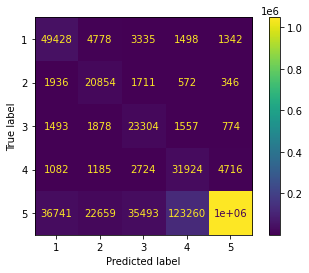

In [36]:
plot_confusion_matrix(clf, tf, data['rating'])

In [68]:
data

,slug,category,content,rating,lemm,predict
0,backstage at tilles center,arts,"[thanks, providing, insights, really, enjoy, v...",5,thanks providing insight really enjoy variety ...,5
1,backstage at tilles center,arts,"[thanks, providing, insights, really, enjoy, v...",5,thanks providing insight really enjoy variety ...,5
2,backstage at tilles center,music,"[thanks, providing, insights, really, enjoy, v...",5,thanks providing insight really enjoy variety ...,5
3,backstage at tilles center,arts,"[super, excited, see, podcast, grow, many, fun...",5,super excited see podcast grow many fun topic ...,5
4,backstage at tilles center,arts,"[super, excited, see, podcast, grow, many, fun...",5,super excited see podcast grow many fun topic ...,5
...,...,...,...,...,...,...
1425160,what if world stories for kids,kids,"[made, guys, listen, podcast, fun, spot, diffe...",5,made guy listen podcast fun spot difference nu...,5
1425161,inbox besties w kate doster email marketing po...,business,"[discovered, kate, doster, hype, real, heard, ...",5,discovered kate doster hype real heard person ...,5
1425162,the trypod,comedy,"[podcast, well, sit, us, podcast, turned, 30, ...",1,podcast well sit u podcast turned 30 minute ac...,1
1425163,the trypod,comedy,"[really, crappy, ep, 2, 4, guess, winners, wou...",1,really crappy ep 2 4 guess winner would really...,4


In [63]:
len(y_predicted_counts)

1422197

In [55]:
1 == 1.0

True

In [71]:
filtered = data[data['rating'] != data['predict']]
filtered

,slug,category,content,rating,lemm,predict
12,ted talks daily,arts,"[love, podcast, good]",5,love podcast good,4
13,ted talks daily,arts,"[love, podcast, good]",5,love podcast good,4
14,ted talks daily,education,"[love, podcast, good]",5,love podcast good,4
18,ted talks daily,arts,"[much, bs, trying, convince, racist, sexist, c...",3,much b trying convince racist sexist country m...,1
19,ted talks daily,arts,"[much, bs, trying, convince, racist, sexist, c...",3,much b trying convince racist sexist country m...,1
...,...,...,...,...,...,...
1425128,stolen lives true crime,society,"[stories, sad, children, need, protected, keep...",5,story sad child need protected keep good work ...,3
1425134,sleep whispers,society,"[one, top, asmr, sleep, whisper, podcasts, get...",5,one top asmr sleep whisper podcasts get excite...,1
1425135,sleep whispers,society,"[one, top, asmr, sleep, whisper, podcasts, get...",5,one top asmr sleep whisper podcasts get excite...,1
1425155,conversations,society,"[richard, engaged, engaging, sarah, k, however...",5,richard engaged engaging sarah k however like ...,3


In [73]:
filtered['rating'].value_counts()

5    218153
1     10953
4      9707
3      5702
2      4565
Name: rating, dtype: int64

In [75]:
# % of total ratings that were misclassified

np.array(filtered['rating'].value_counts()) / np.array(data['rating'].value_counts())

array([0.17234942, 0.18139812, 0.23316759, 0.19658002, 0.17959007])

In [78]:
compare = dict(zip(np.array(filtered['rating'].value_counts()), np.array(data['rating'].value_counts())))
print(compare)

{218153: 1265760, 10953: 60381, 9707: 41631, 5702: 29006, 4565: 25419}


In [81]:
(np.array(filtered['rating']) - np.array(filtered['predict'])).mean()

1.5709932551790589